In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage

# MagAO-X function definitions
import magaoxFunctions as mf
# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
import PSD_defns as psd

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
print('This notebook is not stale yet!')

This notebook is not stale yet!


In [3]:
# 1 inch flats (8 total)

ca_80 = 80
oversamp_size = 4096
dr_width = 5
ntot_1 = 8 # goes from 1-8
D_full_1 = 25.4*u.mm
k_ll = 1/(D_full_1 * ca_80 / 100)

# initialize variables
npix_diam_1 = []
var_1 = []
surf_pwr_1 = np.zeros((ntot_1, oversamp_size, oversamp_size))

print('Crunching individual PSDs for {} flats ({} total mirrors)'.format(D_full_1, ntot_1)) 
for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert um data to mm

    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_1, ca_80, oversamp_size)
    
    # convert ap_var from mm^2 to nm^2
    ap_var *= 1e6*(u.nm/u.mm) * 1e6*(u.nm/u.mm) # convert variance mm2 to nm2

    # calculate the spatial frequency content
    (delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_80, D_full_1)

    norm_psd = psd.calc_normPSD(pwr_opt, delta_k)
    #print('var test n{}: {:.3f}'.format(ntest+1, np.sum(norm_psd) * (delta_k**2)))
    cal_psd = norm_psd * ap_var # there is function calc_calPSD but that's for a different time

    # calculate the PSD data from the variance-normalized PSD
    (kval, mv_n, mv_c) = psd.calc_radialPSD2(norm_psd, cal_psd, FT_freq, dr_width, k_ll.value)

    print('Finished calculating PSD for surface {}'.format(ntest+1))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_1 = np.zeros((ntot_1, np.shape(kval)[0]))
        mn_psd_1 = np.zeros((ntot_1, np.shape(mv_n)[0]))
        mc_psd_1 = np.zeros((ntot_1, np.shape(mv_c)[0]))

    kval_1[ntest,:] = copy.copy(kval)
    mn_psd_1[ntest,:] = copy.copy(mv_n)
    mc_psd_1[ntest,:] = copy.copy(mv_c)
    npix_diam_1.append(npix_diam)
    var_1.append(ap_var)
    surf_pwr_1[ntest,:,:] = copy.copy(pwr_opt)

# force in the units, they will be the same across each iteration
kval_1 *= kval.unit
mn_psd_1 *= mv_n.unit
mc_psd_1 *= mv_c.unit
var_1 *= ap_var.unit
surf_pwr_1 *= pwr_opt.unit

print('All PSD measurement tests done, begin calculating average PSDs (normalized and calibrated)')

# generate the average PSD
nkval = np.shape(kval_1)[1]

# step 1: Collect the individual surface variances and get the average
avg_tot_var = np.mean(var_1)
avg_tot_rms = np.sqrt(avg_tot_var)

# step 2: Make a collection of variance-normalized PSDs
# mn_psd_1 and mc_psd_1

# Step 3: Take average of collection of variance-normalized PSDs
avg_psd = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd[i] = np.sum(mn_psd_1[:,i].value)/np.shape(mn_psd_1)[0]
    
# Step 3.5: Take average of collection of data calibrated PSDs
avg_psd_data = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd_data[i] = np.sum(mc_psd_1[:,i].value)/np.shape(mc_psd_1)[0]
avg_psd_data *= mc_psd_1.unit

# step 4: scale the average norm PSD by average variance data from Step 1
avg_psd_norm = avg_psd * mn_psd_1.unit * avg_tot_var
# no need on the average data calibrated one because it is already set with the correct units.

# Step 5: Apply the average PSD shape with the radial profile
# The radial profile remains the same (kval_1) because all the data is on the same scales.

print('Finished calculating average PSDs (normalized and calibrated)')

Crunching individual PSDs for 25.4 mm flats (8 total mirrors)
surf unit at n1: mm
var at n1: 9.169 nm2
delta k at n1: 0.00264 1 / mm
PSD normalized: var=1.000
var test n1: 1.000
cal var test n1: 9.169 nm2
norm PSD units n1: mm2
cal PSD units n1: mm2 nm2
Finished calculating PSD for surface 1
surf unit at n2: mm
var at n2: 8.807 nm2
delta k at n2: 0.00264 1 / mm
PSD normalized: var=1.000
var test n2: 1.000
cal var test n2: 8.807 nm2
norm PSD units n2: mm2
cal PSD units n2: mm2 nm2
Finished calculating PSD for surface 2
surf unit at n3: mm
var at n3: 11.048 nm2
delta k at n3: 0.00264 1 / mm
PSD normalized: var=1.000
var test n3: 1.000
cal var test n3: 11.048 nm2
norm PSD units n3: mm2
cal PSD units n3: mm2 nm2
Finished calculating PSD for surface 3
surf unit at n4: mm
var at n4: 6.522 nm2
delta k at n4: 0.00264 1 / mm
PSD normalized: var=1.000
var test n4: 1.000
cal var test n4: 6.522 nm2
norm PSD units n4: mm2
cal PSD units n4: mm2 nm2
Finished calculating PSD for surface 4
surf unit at

In [12]:
1/((ca_80/100)*D_full_1) # absolute lowest spatial frequency

<Quantity 0.0492126 1 / mm>

In [14]:
np.amin(kval_1) # must be above lowest spatial frequency

<Quantity 0.05022184 1 / mm>

In [15]:
np.amax(FT_freq) # max spatial frequency

<Quantity 5.41074257 1 / mm>

In [16]:
np.amax(kval_1) # must be below max spatial frequency

<Quantity 5.40281281 1 / mm>

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

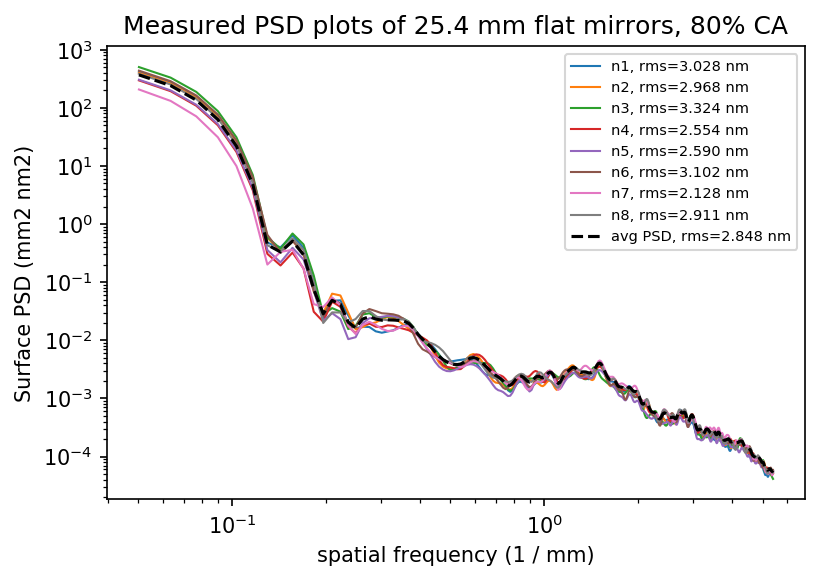

In [4]:
rms_1 = np.sqrt(var_1) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.loglog(kval_1[0,:], avg_psd_norm, 'k--', label='avg PSD, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.title('Measured PSD plots of {} flat mirrors, {}% CA'.format(D_full_1, ca_80))
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

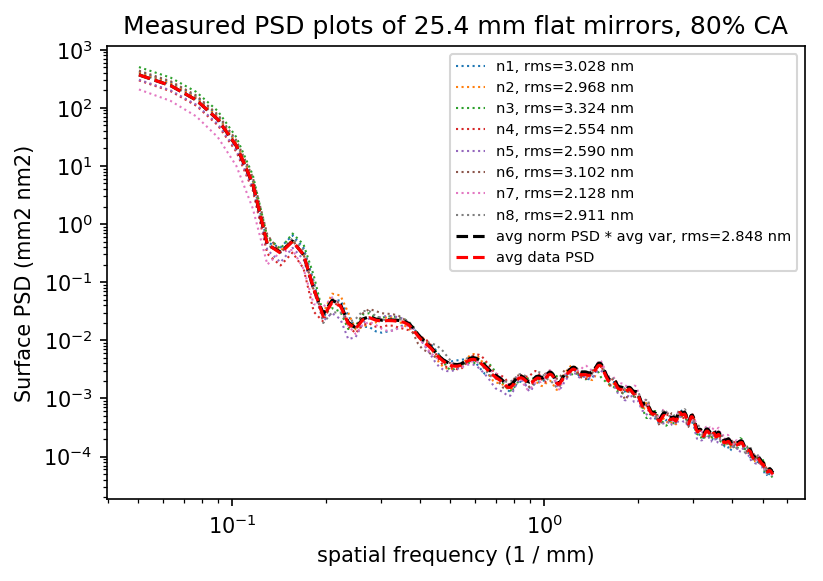

In [31]:
rms_1 = np.sqrt(var_1) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], ':', label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.loglog(kval_1[0,:], avg_psd_norm, 'k--', label='avg norm PSD * avg var, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.loglog(kval_1[0,:], avg_psd_data, 'r--', label='avg data PSD')
plt.title('Measured PSD plots of {} flat mirrors, {}% CA'.format(D_full_1, ca_80))
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

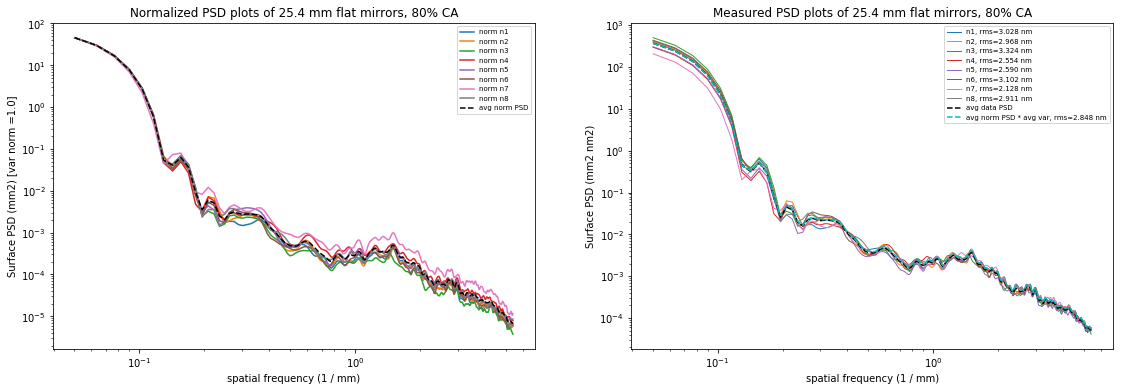

In [27]:
plt.figure(figsize=[19,6])

plt.subplot(1,2,1)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mn_psd_1[ns,:], label='norm n{}'.format(ns+1))
plt.loglog(kval_1[0,:], avg_psd, 'k--', label='avg norm PSD')
plt.title('Normalized PSD plots of {} flat mirrors, {}% CA'.format(D_full_1, ca_80))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({}) [var norm =1.0]'.format(mn_psd_1.unit)) 

plt.subplot(1,2,2)
rms_1 = np.sqrt(var_1)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1.0)
plt.loglog(kval_1[0,:], avg_psd_data, 'k--', label='avg data PSD')
plt.loglog(kval_1[0,:], avg_psd_norm, 'c--', label='avg norm PSD * avg var, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.title('Measured PSD plots of {} flat mirrors, {}% CA'.format(D_full_1, ca_80))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

plt.show()

In [58]:
np.mean(npix_diam_1)

220.0

In [59]:
oversamp_size/(np.mean(npix_diam_1))

18.618181818181817

In [60]:
ovs_new/np.mean(npix_diam_40)

14.925925925925926

In [63]:
ovs_ratio * np.mean(npix_diam_40)

2010.7636363636364

In [61]:
np.mean(npix_diam_40)

108.0

In [64]:
np.mean(npix_diam_1)*ca_new/ca_80

<Quantity 108.26771654>

## Calculate for only the 0.1 mm-1 data.

In [5]:
k_ll = 0.1/u.mm
ca_new = (1/(k_ll*D_full_1))*100
ca_new

<Quantity 39.37007874>

In [65]:
ovs_ratio = oversamp_size/(np.mean(npix_diam_1))
ovs_new = np.int(np.ceil(ovs_ratio * (np.mean(npix_diam_1)*ca_new/ca_80)))
if ovs_new % 2 != 0:
    ovs_new -= 1
ovs_new

2016

In [33]:
def calc_surfPower(optic, full_diam, ca_percent, ovs):
    surf_units = optic.unit
    optic = optic.value
    # check if the optics are same shape. 
    # If the data is not square, pick the shortest side for npix_diam
    if np.shape(optic)[0] <= np.shape(optic)[1]:
        side_diam = np.shape(optic)[0]
    else:
        side_diam = np.shape(optic)[1]
    
    # verify the data to be even, square matrix
    if (np.shape(optic)[0] != np.shape(optic)[1]) or (np.shape(optic)[0] % 2 != 0):
        optic_data = psd.adjustData(optic)
    else:
        optic_data = optic

    # Create the clear aperture mask based on the clear aperture percent
    data_side = np.shape(optic_data)[0]
    npix_diam = np.int(side_diam*ca_percent/100)
    # npix_diam must be even to get the padding to work correctly
    if npix_diam %2 != 0: # if odd
        npix_diam -= 1 # decrease by 1 to force to even
    ap_clear = np.zeros((data_side, data_side), dtype=np.uint8)
    ca_coords = draw.circle(data_side/2, data_side/2, radius=(npix_diam/2))
    ap_clear[ca_coords] = True

    # calculate the mean and variance of the active region of data
    ap_active = optic_data * ap_clear
    ap_active_coords = optic_data[ap_clear==True]
    ap_avg = np.mean(ap_active_coords)
    ap_var = np.var(ap_active_coords)*surf_units*surf_units

    # Subtract the mean from the data
    ap_submean = (ap_active - ap_avg) * ap_clear

    # build the Hann 2D window
    hannWin = psd.han2d((npix_diam, npix_diam))
    # zero-pad the window to fit with the full aperture dimensions
    pad_side = np.int((np.shape(optic_data)[0] - npix_diam)/2)
    pad_hann = np.pad(hannWin, pad_side, mf.pad_with) * ap_clear

    # oversample the windowed data and take FFT for the power
    optic_ovs = np.pad(ap_submean * pad_hann, np.int((ovs_new-data_side)/2), mf.pad_with) *surf_units
    power_optic = psd.calcPower2(optic_ovs)/(surf_units*surf_units)
    
    return power_optic, npix_diam, ap_var

In [67]:
# initialize variables
npix_diam_40 = []
var_40 = []
surf_pwr_40 = np.zeros((ntot_1, ovs_new, ovs_new))

print('Crunching individual PSDs for {} flats ({} total mirrors)'.format(D_full_1, ntot_1)) 
for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert um data to mm
    print('surf unit at n{}: {}'.format(ntest+1, surf_data.unit))

    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = calc_surfPower(surf_data, D_full_1, ca_new, oversamp_size)
    
    # convert ap_var from mm^2 to nm^2
    ap_var *= 1e6*(u.nm/u.mm) * 1e6*(u.nm/u.mm) # convert variance mm2 to nm2
    print('var at n{}: {:.3f}'.format(ntest+1, ap_var))

    # calculate the spatial frequency content
    (delta_k, FT_freq) = psd.calc_spatialFreq(np.int(ovs_new), npix_diam, ca_new, D_full_1)
    print('delta k at n{}: {:.5f}'.format(ntest+1, delta_k))

    norm_psd = psd.calc_normPSD(pwr_opt, delta_k)
    print('var test n{}: {:.3f}'.format(ntest+1, np.sum(norm_psd) * (delta_k**2)))
    cal_psd = norm_psd * ap_var # there is function calc_calPSD but that's for a different time
    print('cal var test n{}: {:.3f}'.format(ntest+1, np.sum(cal_psd) * (delta_k**2)))

    # calculate the PSD data from the variance-normalized PSD
    #(kval, mean_val) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)
    (kval, mv_n, mv_c) = psd.calc_radialPSD2(norm_psd, cal_psd, FT_freq, dr_width, k_ll.value)
    print('norm PSD units n{}: {}'.format(ntest+1, mv_n.unit)) # should be mm2
    print('cal PSD units n{}: {}'.format(ntest+1, mv_c.unit))  # should be mm2 nm2

    print('Finished calculating PSD for surface {}'.format(ntest+1))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_40 = np.zeros((ntot_1, np.shape(kval)[0]))
        mn_psd_40 = np.zeros((ntot_1, np.shape(mv_n)[0]))
        mc_psd_40 = np.zeros((ntot_1, np.shape(mv_c)[0]))

    kval_40[ntest,:] = copy.copy(kval)
    mn_psd_40[ntest,:] = copy.copy(mv_n)
    mc_psd_40[ntest,:] = copy.copy(mv_c)
    npix_diam_40.append(npix_diam)
    var_40.append(ap_var)
    surf_pwr_40[ntest,:,:] = copy.copy(pwr_opt)

# force in the units, they will be the same across each iteration
kval_40 *= kval.unit
mn_psd_40 *= mv_n.unit
mc_psd_40 *= mv_c.unit
var_40 *= ap_var.unit
surf_pwr_40 *= pwr_opt.unit

print('All PSD measurement tests done, begin calculating average PSDs (normalized and calibrated)')

# generate the average PSD
nkval = np.shape(kval_40)[1]

# step 1: Collect the individual surface variances and get the average
avg_tot_var_40 = np.mean(var_40)
avg_tot_rms_40 = np.sqrt(avg_tot_var_40)

# step 2: Make a collection of variance-normalized PSDs
# mn_psd_1 and mc_psd_1

# Step 3: Take average of collection of variance-normalized PSDs
avg_psd_40 = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd_40[i] = np.sum(mn_psd_40[:,i].value)/np.shape(mn_psd_40)[0]
    
# Step 3.5: Take average of collection of data calibrated PSDs
avg_psd_data_40 = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd_data_40[i] = np.sum(mc_psd_40[:,i].value)/np.shape(mc_psd_40)[0]
avg_psd_data_40 *= mc_psd_40.unit

# step 4: scale the average norm PSD by average variance data from Step 1
avg_psd_norm_40 = avg_psd_40 * mn_psd_40.unit * avg_tot_var_40
# no need on the average data calibrated one because it is already set with the correct units.

# Step 5: Apply the average PSD shape with the radial profile
# The radial profile remains the same (kval_1) because all the data is on the same scales.

print('Finished calculating average PSDs (normalized and calibrated)')

Crunching individual PSDs for 25.4 mm flats (8 total mirrors)
surf unit at n1: mm
var at n1: 0.604 nm2
delta k at n1: 0.00536 1 / mm
PSD normalized: var=1.000
var test n1: 1.000
cal var test n1: 0.604 nm2
norm PSD units n1: mm2
cal PSD units n1: mm2 nm2
Finished calculating PSD for surface 1
surf unit at n2: mm
var at n2: 0.522 nm2
delta k at n2: 0.00536 1 / mm
PSD normalized: var=1.000
var test n2: 1.000
cal var test n2: 0.522 nm2
norm PSD units n2: mm2
cal PSD units n2: mm2 nm2
Finished calculating PSD for surface 2
surf unit at n3: mm
var at n3: 0.709 nm2
delta k at n3: 0.00536 1 / mm
PSD normalized: var=1.000
var test n3: 1.000
cal var test n3: 0.709 nm2
norm PSD units n3: mm2
cal PSD units n3: mm2 nm2
Finished calculating PSD for surface 3
surf unit at n4: mm
var at n4: 0.381 nm2
delta k at n4: 0.00536 1 / mm
PSD normalized: var=1.000
var test n4: 1.000
cal var test n4: 0.381 nm2
norm PSD units n4: mm2
cal PSD units n4: mm2 nm2
Finished calculating PSD for surface 4
surf unit at n

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

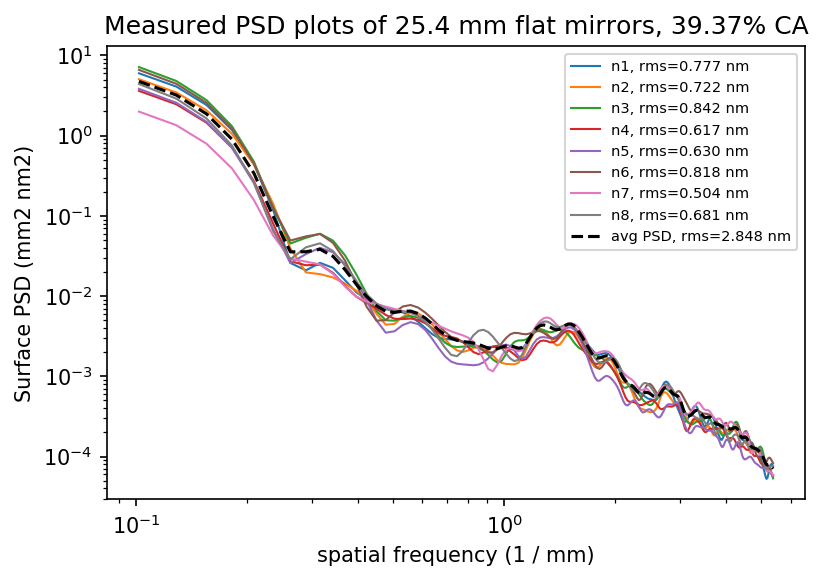

In [78]:
rms_40 = np.sqrt(var_40) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_40[ns,:], mc_psd_40[ns,:], label='n{}, rms={:.3f}'.format(ns+1, rms_40[ns]), linewidth=1)
plt.loglog(kval_40[0,:], avg_psd_norm_40, 'k--', label='avg PSD, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.title('Measured PSD plots of {} flat mirrors, {:.2f}% CA'.format(D_full_1, ca_new))
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_40.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_40.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

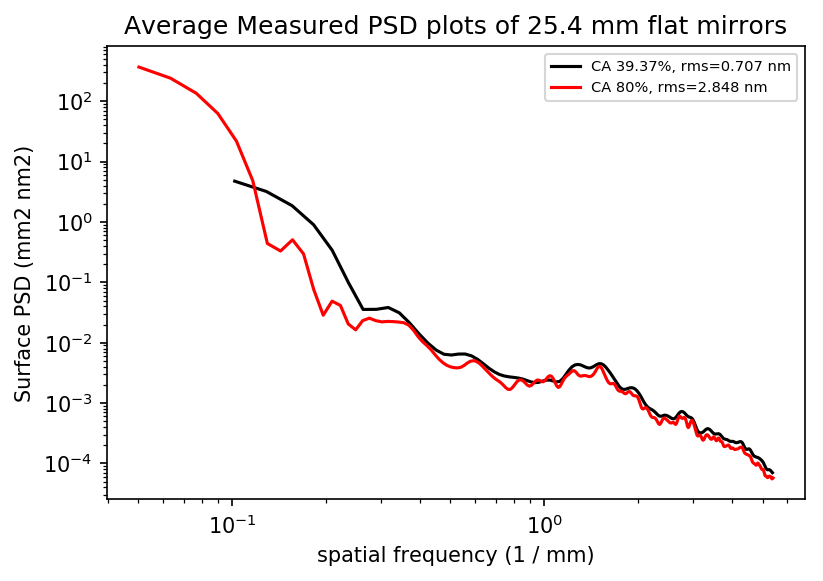

In [79]:
rms_40 = np.sqrt(var_40) # converts mm to nm
plt.figure(dpi=150)
#for ns in range(0,ntot_1):
#    plt.loglog(kval_40[ns,:], mc_psd_40[ns,:], label='CA {:.0f}%, n{}, rms={:.3f}'.format(ca_new, ns+1, rms_40[ns]), linewidth=1)
plt.loglog(kval_40[0,:], avg_psd_norm_40, 'k', label='CA {:.2f}%, rms={:.3f}'.format(ca_new, np.sqrt(avg_tot_var_40)))
plt.title('Average Measured PSD plots of {} flat mirrors'.format(D_full_1))
#for ns in range(0,ntot_1):
#    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], label='CA {:.0f}%, n{}, rms={:.3f}'.format(ca_80, ns+1, rms_1[ns]), linewidth=1)
plt.loglog(kval_1[0,:], avg_psd_norm, 'r', label='CA {:.0f}%, rms={:.3f}'.format(ca_80, np.sqrt(avg_tot_var)))
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_40.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_40.unit)) 

## Build the PSD plots
Solving for alpha, beta, l0, and L0

In [41]:
def calc_beta(alpha, var, D_clear, npix_diam):
    kmin = 1 / D_clear
    kmax = 1/ (2 * D_clear / npix_diam)
    
    if alpha == 2:
        beta = var / ( 2* np.pi * np.log(kmax/kmin) )
    else: # when beta is not 2
        beta = var * (alpha - 2) / (2 * np.pi * ( (kmin**(2 - alpha)) - (kmax**(2 - alpha)) ) )
    
    return beta

In [110]:
# alpha and beta should be fit on the mid-spatial frequency content region
# choose the cut-off for position
klim = 0.15
#klim = np.amin(kval_1[0].value)
k_size = np.shape(kval_1[0])[0]
kfit = np.zeros((k_size))
for kn in range(0,k_size):
    kfit[kn] = np.abs(kval_1[0,kn].value - klim)
klim_ind = np.argmin(kfit)
k_range = kval_1[0,klim_ind:k_size]

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

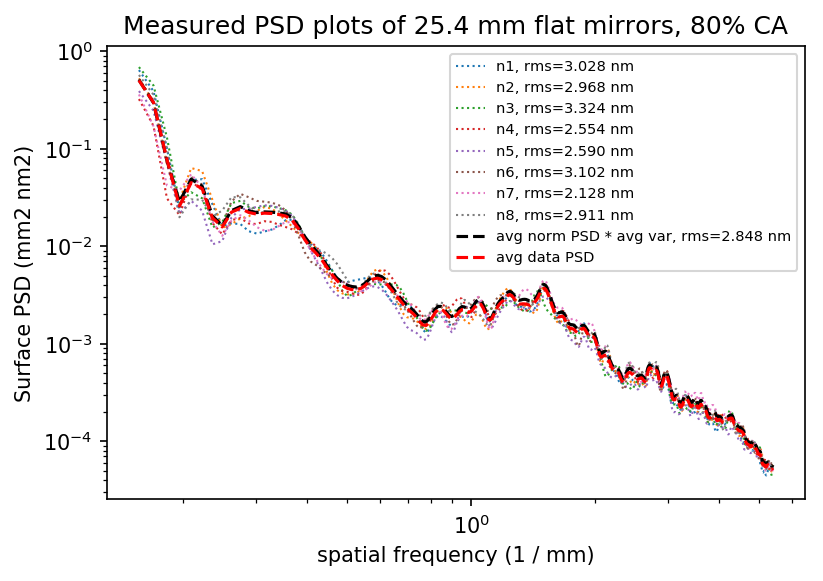

In [112]:
rms_1 = np.sqrt(var_1) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,klim_ind:k_size], mc_psd_1[ns,klim_ind:k_size], ':', label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.loglog(kval_1[0,klim_ind:k_size], avg_psd_norm[klim_ind:k_size], 'k--', label='avg norm PSD * avg var, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.loglog(kval_1[0,klim_ind:k_size], avg_psd_data[klim_ind:k_size], 'r--', label='avg data PSD')
plt.title('Measured PSD plots of {} flat mirrors, {}% CA'.format(D_full_1, ca_80))
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

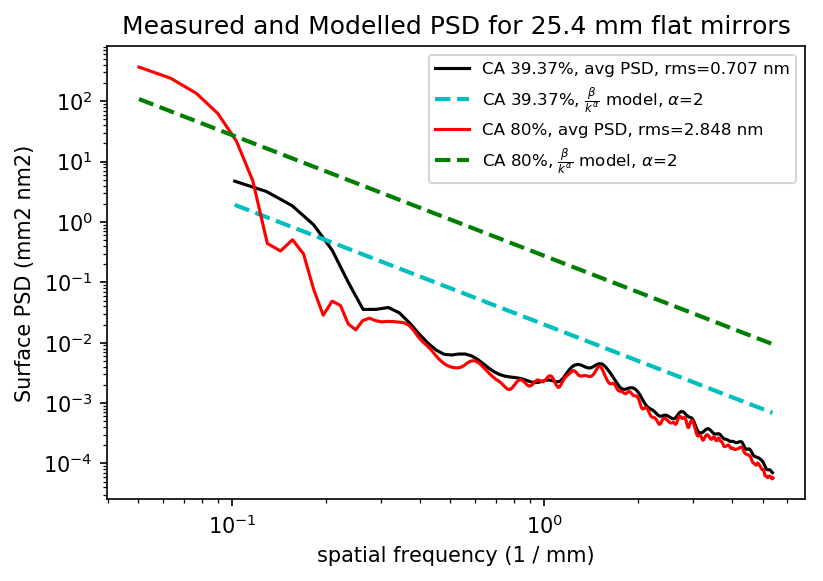

In [80]:
# alpha and beta should be fit on the mid-spatial frequency content region
# choose the cut-off for position
klim = 0.1
#klim = np.amin(kval_1[0].value)
k_size = np.shape(kval_40[0])[0]
kfit = np.zeros((k_size))
for kn in range(0,k_size):
    kfit[kn] = np.abs(kval_40[0,kn].value - klim)
klim_ind = np.argmin(kfit)
k_range = kval_40[0,klim_ind:k_size]

a2 = 2# estimate for OAP
b2 = calc_beta(a2, avg_tot_var_40, D_full_1*ca_new/100, np.mean(npix_diam_40))
a2_fit = b2/((k_range**a2))
b1 = calc_beta(a2, avg_tot_var, D_full_1*ca_80/100, np.mean(npix_diam_1))
a1_fit = b1/((kval_1[0]**a2))
#a2_fit1 = b2/((avg_tot_var_40**a2)*(k_range**a2))

# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1)
plt.figure(dpi=150)
plt.loglog(kval_40[0,:], avg_psd_norm_40, 'k', label='CA {:.2f}%, avg PSD, rms={:.3f}'.format(ca_new, np.sqrt(avg_tot_var_40)))
plt.loglog(k_range, a2_fit, 'c--', label='CA {:.2f}%, {} model, {}={}'.format(ca_new, r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
plt.loglog(kval_1[0,:], avg_psd_norm, 'r', label='CA {:.0f}%, avg PSD, rms={:.3f}'.format(ca_80, np.sqrt(avg_tot_var)))
plt.loglog(kval_1[0], a1_fit, 'g--', label='CA {:.0f}%, {} model, {}={}'.format(ca_80, r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model, {}={}'.format(r'$\frac{\beta}{(var_{avg}k)^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
plt.title('Measured and Modelled PSD for {} flat mirrors'.format(D_full_1))
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':8})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

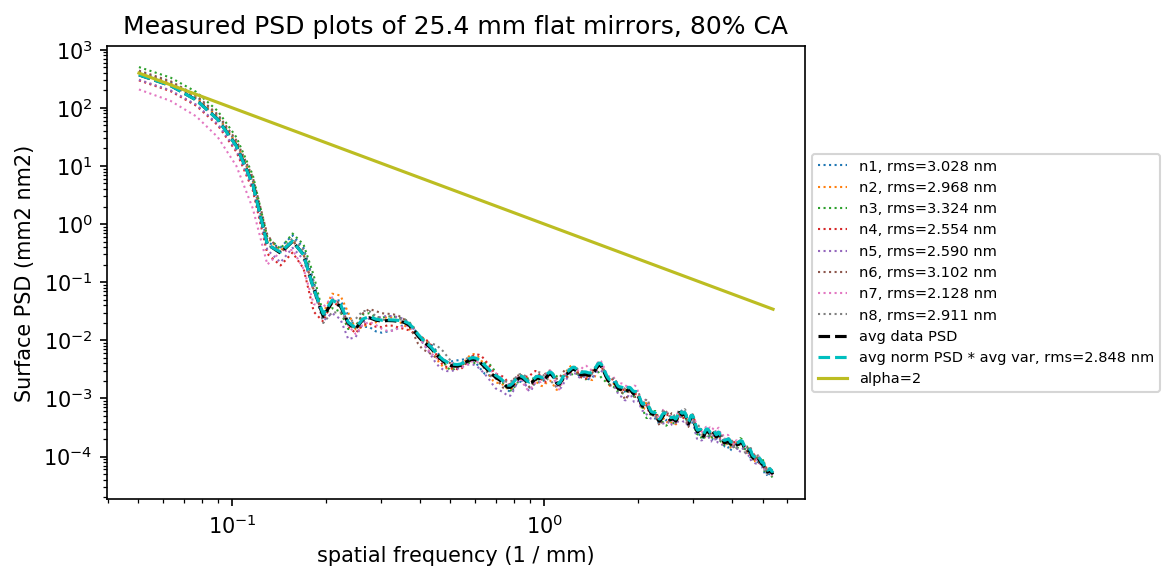

In [51]:
rms_1 = np.sqrt(var_1)

plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], ':', label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1.0)
plt.loglog(kval_1[0,:], avg_psd_data, 'k--', label='avg data PSD')
plt.loglog(kval_1[0,:], avg_psd_norm, 'c--', label='avg norm PSD * avg var, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.loglog(kval_1[0][:], alpha_fit, label='alpha={}'.format(alpha))
plt.title('Measured PSD plots of {} flat mirrors, {}% CA'.format(D_full_1, ca_80))
plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 